#### Author: Domitille Jarrige
#### Date: 2022-09-30

# Spacial analysis of _Dioszegia hungarica_ PDD-24b-2 
### ITS sequence on WGS v2 data and 97% identity threshold:


#### Module imports

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import pandas as pd
import geopy
from geopy.extra.rate_limiter import RateLimiter
from shapely.geometry import Point
import re
import random

%matplotlib inline 
plt.rcParams["figure.figsize"] = [25, 20]

geolocator = geopy.Nominatim(user_agent="IGNFrance")

geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

In [2]:
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

### Data cleaning

The results of the `sra_meta-analyses_wgs_v2.sh` script are collected and concatenated using the following bash command line: 

Bash command line:
`cat results/*.tmp  > results/results_blast_wgs_v2_97perc.tsv`

The data is then processed as follow :

#### Recovering negative megablast results

Bash command line:
`grep --text -B 1 "0 hits" results_blast_wgs_v2.tsv | grep Database | cut -f 3 -d " " > list_0_hits_wholeITS.txt`

#### Recovering and formatting positive megablast results

Bash command lines:

`echo query_acc_ver,subject_acc_ver,%identity,alignment_length,mismatches,gap_opens,q_start,q_end,s_start,s_end,evalue,bit_score > results_blast_wgs_v2_97perc.csv`


`cat results_blast_wgs_v2_97perc.tsv | grep -v -F "#" | tr "\t" "," >> results_blast_wgs_v2_97perc.csv`

#### Building reference list of negative runs

In [3]:
with open("list_0_hits_wholeITS.txt", "r") as file_in :
    list_negative_accession = [run[:-1] for run in file_in.readlines()]

#### Building reference lists of positive runs

##### Megablast results table loading

In [4]:
wgs_v2_df = pd.read_csv("results_blast_wgs_v2_97perc_wholeITS.csv")

The run accessions are extracted from the BLAST result table using a regular expression and added in a new column.

In [5]:
accession = r":([0-9A-Z]+)\."

for m in range(len(wgs_v2_df)):
    match = re.findall(accession, str(wgs_v2_df.loc[m, "subject_acc_ver"]))
    if len(match):
        wgs_v2_df.loc[m, "Run"] = match[0]

#### Megablast hits filtering
The choice of these filters is justified at the end of this notebook.
##### _Dioszegia hungarica_-containing WGS accessions
List of accessions with megablast hits with : 
- with an E-value of 10e-10 at most
- that map at least 15 nt into the ITS1 and ITS2 sequences (excluding hits that span nearly exclusively the 5.8s and 25s rRNA genes)



In [6]:
list_accession = list(wgs_v2_df[(wgs_v2_df["evalue"] <= 10e-10) & ((wgs_v2_df["q_start"] <= 128) | (wgs_v2_df["q_end"] >= 309)) & 
                                (wgs_v2_df["q_start"] <= 418)].groupby("Run").count().index)

##### _Dioszegia_ species-containing WGS accessions

List of accessions with megablast hits:
- with an E-value of 10e-10 at most
- that map into the 5.8s rRNA gene
- with an identity of at least 99%

In [7]:
list_dio_accession = list(wgs_v2_df[(wgs_v2_df["%identity"] >= 99) & (wgs_v2_df["evalue"] <= 10e-10) & 
                                       (wgs_v2_df["alignment_length"] >= 55) & (wgs_v2_df["q_start"] <= (433-15))].groupby("Run").count().index)

#### Loading metadata table

In [8]:
df_meta = pd.read_csv("../../../../collaborations_diverses/biogeographic_analyses/data/WGS_metaSRA_v2.tsv", sep="\t")

#### Results of the megablast search of homologs of _D. hungarica_ PDD-24b-2 ITS region are added to the metadata table

Default results will be "ND" (not determined) for runs where the script failed to complete the MegaBLAST analysis (because of server error while retrieving the sequence data for instance).

In [9]:
df_meta["Presence_D.hungarica"] = "ND"
df_meta["Presence_Dioszegia_species"] = "ND"

In [10]:
for k in range(len(df_meta)):     
    if df_meta.loc[k, "Run"] in list_accession:
        df_meta.loc[k, "Presence_D.hungarica"] = True
        df_meta.loc[k, "Presence_Dioszegia_species"] = True
    
    elif df_meta.loc[k, "Run"] in list_negative_accession:
        df_meta.loc[k, "Presence_D.hungarica"] = False
        df_meta.loc[k, "Presence_Dioszegia_species"] = False
        
    elif df_meta.loc[k, "Run"] in list_dio_accession:
        df_meta.loc[k, "Presence_D.hungarica"] = False
        df_meta.loc[k, "Presence_Dioszegia_species"] = True

#### Supplementary table 3 export

In [11]:
df_meta.to_csv("results_D_hungarica_wgs_v2.tsv", sep="\t", index=False)

### Final results processing and plotting

The data is subdivised in separate dataframes for downstream processing.

In [12]:
df_neg = df_meta[df_meta["Presence_D.hungarica"] == False]
df_pos = df_meta[df_meta["Presence_D.hungarica"] == True]
df_nd = df_meta[df_meta["Presence_D.hungarica"] == "ND"]
df_dio = df_meta[(df_meta["Presence_Dioszegia_species"] == True) & (df_meta["Presence_D.hungarica"] == False)]

#### GPS coordinates processing

This custom function converts the coordinates data from the metadata table in a format usable by GeoPandas.

In [13]:
def convert_latlon(coordinates):
    """
    Change N, E, W, S coordinates in a tuple of simple
    decimal coordinates.
    """
    list_coor = str(coordinates).split()
    if len(list_coor) == 4 :
        if list_coor[1] == "S":
            list_coor[0] = -float(list_coor[0])
        if list_coor[3] == "W":
            list_coor[2] = -float(list_coor[2])
        return Point(float(list_coor[2]), float(list_coor[0]))
    else:
        return

The coordinates are converted to a format suitable for GeoPandas, and GeoDataFrames are produced from each dataframe.

In [14]:
%%capture --no-display
df_meta["Coordinates"] = "NA"
df_pos["Coordinates"] = "NA"
df_neg["Coordinates"] = "NA"
df_dio["Coordinates"] = "NA"

for n in range(len(df_meta)):
    df_meta["Coordinates"].iloc[n] = convert_latlon(df_meta["lat_lon"].iloc[n])

for n in range(len(df_neg)):
    df_neg["Coordinates"].iloc[n] = convert_latlon(df_neg["lat_lon"].iloc[n])
    
for n in range(len(df_pos)):    
    df_pos["Coordinates"].iloc[n] = convert_latlon(df_pos["lat_lon"].iloc[n])
    
for n in range(len(df_dio)):    
    df_dio["Coordinates"].iloc[n] = convert_latlon(df_dio["lat_lon"].iloc[n])


df_meta_locations = gpd.GeoDataFrame(columns=("geometry", "address"))
df_neg_locations = gpd.GeoDataFrame(columns=("geometry", "address"))
df_pos_locations = gpd.GeoDataFrame(columns=("geometry", "address"))
df_dio_locations = gpd.GeoDataFrame(columns=("geometry", "address"))

df_meta_locations.geometry = df_meta[df_meta["Coordinates"] != "NA"]["Coordinates"]
df_meta_locations.address = df_meta[df_meta["Coordinates"] != "NA"]["geo_loc_name"]

df_neg_locations.geometry = df_neg[df_neg["Coordinates"] != "NA"]["Coordinates"]
df_neg_locations.address = df_neg[df_neg["Coordinates"] != "NA"]["geo_loc_name"]

df_pos_locations.geometry = df_pos[df_pos["Coordinates"] != "NA"]["Coordinates"]
df_pos_locations.address = df_pos[df_pos["Coordinates"] != "NA"]["geo_loc_name"]

df_dio_locations.geometry = df_dio[df_dio["Coordinates"] != "NA"]["Coordinates"]
df_dio_locations.address = df_dio[df_dio["Coordinates"] != "NA"]["geo_loc_name"]

#### Environmental prevalence of _D. hungarica_ and _Dioszegia_ species

In [15]:
list_abs = []
list_pre = []
list_nd = []
list_dio = []
list_env = df_meta.groupby("env_type").count().index
for env in list_env:
    tmp_df = df_meta[df_meta["env_type"] == env]
    presence = len(tmp_df[tmp_df["Presence_D.hungarica"] == True])
    absence = len(tmp_df[tmp_df["Presence_D.hungarica"] == False])
    dioszegia = len(tmp_df[(tmp_df["Presence_D.hungarica"] == False) & (tmp_df["Presence_Dioszegia_species"] == True)])
    nd = len(tmp_df[tmp_df["Presence_D.hungarica"] == "ND"])
    list_abs.append(absence)
    list_pre.append(presence)
    list_nd.append(nd)
    list_dio.append(dioszegia)

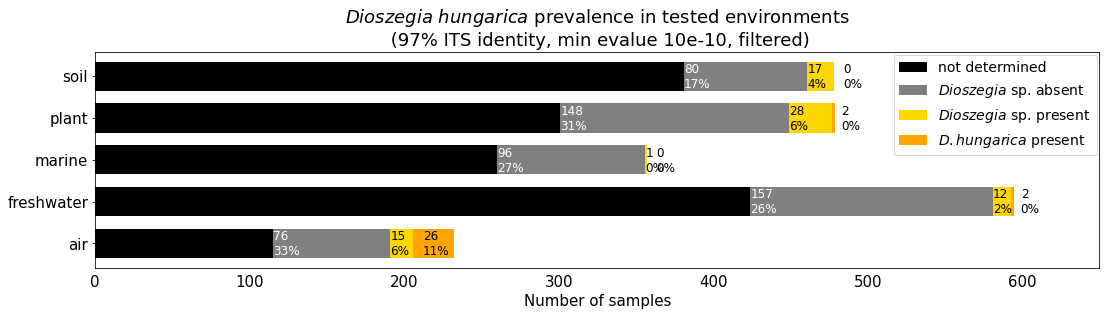

In [16]:
fig = plt.figure()
fig.set_size_inches(18, 5)

list_labels_absent = []
list_labels_present = []
list_labels_dio = []
list_labels = df_meta.groupby("env_type").count().index

for a, p, n, d in zip(list_abs, list_pre, list_nd, list_dio):
    list_labels_absent.append(f"{a}\n{a/(a+p+n+d)*100:.0f}%")
    list_labels_present.append(f"{p}\n{p/(a+p+n+d)*100:.0f}%")
    list_labels_dio.append(f"{d}\n{d/(a+p+n+d)*100:.0f}%")

plt.barh(list_labels, list_nd, label="not determined", color="black", height = 0.7)
plt.barh(list_labels, list_abs, label="$Dioszegia$ sp. absent", color="gray", height = 0.7, left=list_nd)
plt.barh(list_labels, list_dio, label="$Dioszegia$ sp. present", color="gold", height = 0.7, left=[n+a for n, a in zip(list_nd, list_abs)])
plt.barh(list_labels, list_pre, label="$D. hungarica$ present", color="orange", height = 0.7, left=[n+a+d for n, a, d in zip(list_nd, list_abs, list_dio)])
plt.xlim(0,650)

for k in range(1,len(list_labels)+1):
    plt.annotate(list_labels_absent[k-1], xy=(list_nd[k-1]+0.1, k-1.28), color="white", fontsize=12)
    plt.annotate(list_labels_dio[k-1], xy=(list_nd[k-1]+list_abs[k-1]+0.1, k-1.28), color="black", fontsize=12)
    plt.annotate(list_labels_present[k-1], xy=(list_nd[k-1]+list_abs[k-1]+list_dio[k-1]+6, k-1.28), color="black", fontsize=12)

plt.tick_params(labelsize=15)
plt.title('$Dioszegia$ $hungarica$ prevalence in tested environments\n (97% ITS identity, min evalue 10e-10, filtered)', size=18)
plt.xlabel("Number of samples", size=15)
plt.legend(loc=(0.795, 0.52), fontsize=14)
plt.tick_params(bottom=False)
plt.subplots_adjust(bottom= 0.2, top = 0.8)
plt.show()

#### Repartition of positive Samples according to their environment type

In [17]:
list_air, list_plant, list_soil, list_water, list_marine = [], [], [], [], []

for df in [df_meta, df_dio, df_pos]:
    list_air.append(len(df[df["env_type"] == "air"])/len(df)*100)
    list_plant.append(len(df[df["env_type"] == "plant"])/len(df)*100)
    list_soil.append(len(df[df["env_type"] == "soil"])/len(df)*100)
    list_water.append(len(df[df["env_type"] == "freshwater"])/len(df)*100)
    list_marine.append(len(df[df["env_type"] == "marine"])/len(df)*100)

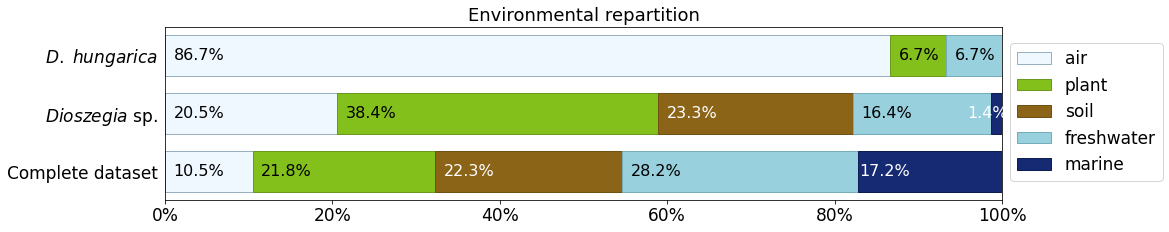

In [18]:
%%capture --no-display
fig = plt.figure()
fig.set_size_inches(15, 4)


list_labels = [f"Complete dataset", f"$Dioszegia$ sp.", f"$D.$ $hungarica$"]

list_labels_air = [f"{a:.1f}%" for a in list_air]
list_labels_plant = [f"{p:.1f}%" for p in list_plant]
list_labels_soil = [f"{s:.1f}%" for s in list_soil]
list_labels_water = [f"{w:.1f}%" for w in list_water]
list_labels_marine = [f"{m:.1f}%" for m in list_marine]

plt.barh(list_labels, list_air, label="air", color="aliceblue", height = 0.7, edgecolor="#97AFBF")
plt.barh(list_labels, list_plant, label="plant", color="#84C01C", height = 0.7, edgecolor="#6B991C", left=list_air)
plt.barh(list_labels, list_soil, label="soil", color="#8C6418", height = 0.7, edgecolor="#705013", left=[a+p for a, p in zip(list_air, list_plant)])
plt.barh(list_labels, list_water, label="freshwater", color="#98D0DE", height = 0.7, edgecolor="#75ACB9", left=[a+p+s for a, p, s in zip(list_air, list_plant, list_soil)])
plt.barh(list_labels, list_marine, label="marine", color="#162A73", height = 0.7, edgecolor="#0E1D52", left=[a+p+s+w for a, p, s, w in zip(list_air, list_plant, list_soil, list_water)])
plt.xlim(0,100)

for k in range(0,len(list_labels)):
    if list_labels_air[k] != "0.0%":
        plt.annotate(list_labels_air[k], xy=(1, k-0.08), color="black", fontsize=16)
    if list_labels_plant[k] != "0.0%":
        plt.annotate(list_labels_plant[k], xy=(list_air[k]+1, k-0.08), color="black", fontsize=16)
    if list_labels_soil[k] != "0.0%":
        plt.annotate(list_labels_soil[k], xy=(list_air[k]+list_plant[k]+1, k-0.08), color="white", fontsize=16)
    if list_labels_water[k] != "0.0%":
        plt.annotate(list_labels_water[k], xy=(list_air[k]+list_plant[k]+list_soil[k]+1, k-0.08), color="black", fontsize=16)
    if list_labels_marine[k] != "0.0%":
        if list_labels_marine[k] == "1.4%":
            plt.annotate(list_labels_marine[k], xy=(list_air[k]+list_plant[k]+list_soil[k]+list_water[k]+-2.8, k-0.08), color="white", fontsize=16)
        else:
            plt.annotate(list_labels_marine[k], xy=(list_air[k]+list_plant[k]+list_soil[k]+list_water[k]+0.1, k-0.08), color="white", fontsize=16)

plt.tick_params(labelsize=17)
plt.title('Environmental repartition', size=18)
plt.legend(loc=(1.01, 0.11), fontsize=17)
plt.subplots_adjust(bottom= 0.2, top = 0.8)
plt.tick_params(left=False)
plt.gca().set_xticklabels([f'{x:.0f}%' for x in plt.gca().get_xticks()])
plt.show()

#### _D. hungarica_ and _Dioszegia_ species distribution around the world

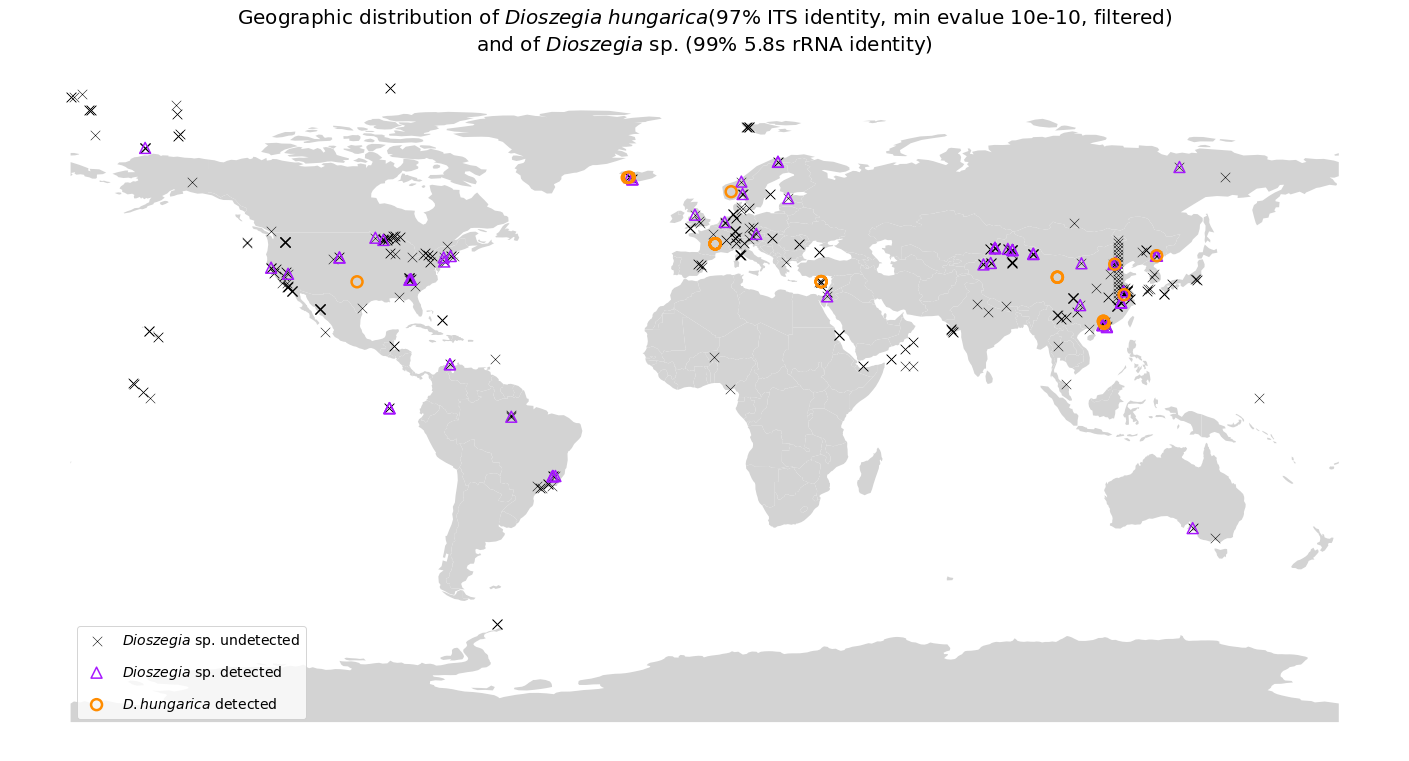

In [19]:
map = world.plot(color ="lightgray")
map.set_axis_off()

n_neg  = len(df_neg)
n_pos = len(df_pos)
#n_nd = len(df_nd)
n_dio = len(df_dio)



df_neg_locations.plot(ax=map, marker = "x", color = "black", alpha=1, linewidth=0.5, 
                                markersize = 90, label=f"$Dioszegia$ sp. undetected")

df_dio_locations.plot(ax=map, marker = "^", color = "none", alpha=1, linewidth=1.5, 
                                edgecolor = "#A717FF", markersize = 120, label=f"$Dioszegia$ sp. detected")

df_pos_locations.plot(ax=map, marker = "o", color = "none", alpha=1, linewidth=2.5, 
                                        edgecolor = "darkorange", markersize = 120, label=f"$D. hungarica$ detected")



leg = map.legend(loc=(0.05, 0.05), labelspacing=1, fontsize=14, facecolor = "white",  labelcolor="black", fancybox=True)
#leg.set_title("Sample source")
title = leg.get_title()
title.set_color("white")
title.set_size(17)

plt.title("Geographic distribution of $Dioszegia$ $hungarica$(97% ITS identity, min evalue 10e-10, filtered)\nand of $Dioszegia$ sp. (99% 5.8s rRNA identity)", fontsize=20)
plt.show()

### Megablast hits filtering criteria

To pick the hits filtering criteria, we first looked at the distribution of megablast hits along the ITS region.

#### Repartition of all megablast hits on _D. hungarica_ PDD-24b-2 ITS region

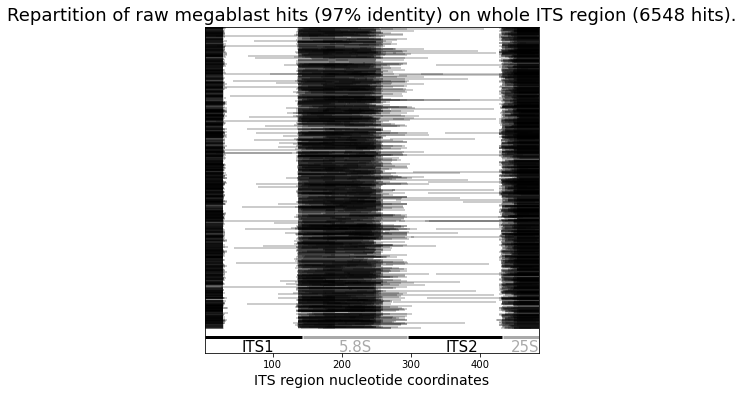

In [20]:
fig, ax = plt.subplots()
fig.set_size_inches(6, 6)
ax.set_xlim(1, 486)
ax.set_ylim(-50, 1000)

list_start_raw = [start for start in wgs_v2_df["q_start"]]
list_end_raw = [end for end in wgs_v2_df["q_end"]]

for n in range(len(list_start_raw)):
    y = random.randrange(30,1000,1)
    list_start_raw[n] = (list_start_raw[n], y)
    list_end_raw[n] = (list_end_raw[n], y)

seg_raw = LineCollection(zip(list_start_raw, list_end_raw), colors="black", linewidths=2, alpha=0.2)    

its = LineCollection([
                      [(1, 0), (142, 0)], 
                      [(143, 0), (294, 0)], 
                      [(295, 0), (432, 0)], 
                      [(433, 0), (486, 0)]
                      ], 
                     colors=["black", "darkgray", "black", "darkgray"], linewidths=3)

ax.add_collection(seg_raw)
ax.add_collection(its)
plt.annotate("ITS1", xy=(55, -45), color="black", fontsize=15)
plt.annotate("5.8S", xy=(195, -45), color="darkgray", fontsize=15)
plt.annotate("ITS2", xy=(350, -45), color="black", fontsize=15)
plt.annotate("25S", xy=(445, -45), color="darkgray", fontsize=15)
plt.yticks([])
plt.xlabel("ITS region nucleotide coordinates", size=14)

plt.title(f"Repartition of raw megablast hits (97% identity) on whole ITS region ({len(list_start_raw)} hits).", size=18)
plt.show()

Many reads were completely or nearly completely mapping (less than 15 nt mapping on ITS1 or ITS2) on the 5.8s rRNA gene and the beginning 54 nt of the 25s rRNA gene. Many other hits were mapping exclusively to the first ~30 nt of ITS1

To determine wether these regions could be informative for discriminate between species or genra, simple BLASTN 2.13.0+ searches in NCBI rRNA_typestrains/ITS_RefSeq_Fungi database were performed.

>Zheng Zhang, Scott Schwartz, Lukas Wagner, and Webb Miller (2000), "A greedy algorithm for aligning DNA sequences", _J Comput Biol 2000_; 7(1-2):203-14.

In contrast to the complete ITS1 and ITS2 sequences, which were powerful for identifying _D. hungarica_ (See below):


##### Excerpt of BLASTn results on _D. hungarica_ PDD-24b-2 ITS1 sequence

|Description|Scientific Name|Max Score|Total Score|Query Cover|E value|Per. Ident|Acc. Len|Accession|
|-----------|---------------|---------|-----------|-----------|-------|----------|--------|---------|
|Dioszegia hungarica CBS 4214 ITS region; from TYPE material|Dioszegia hungarica|261|261|100%|2e-70|100.00%|491|NR_073227.1|
|Dioszegia antarctica CBS 10920 ITS region; from TYPE material|Dioszegia antarctica|195|195|100%|2e-50|91.67%|445|NR_159813.1|
|Dioszegia statzelliae CBS 8925 ITS region; from TYPE material|Dioszegia statzelliae|185|185|100%|1e-47|90.41%|485|NR_156191.1|
|Dioszegia patagonica UFMG 195 ITS region; from TYPE material|Dioszegia patagonica|169|169|92%|1e-42|89.63%|485|NR_158412.1|


##### Excerpt of BLASTn results on _D. hungarica_ PDD-24b-2 ITS2 sequence

|Description|Scientific Name|Max Score|Total Score|Query Cover|E value|Per. Ident|Acc. Len|Accession|
|-----------|---------------|---------|-----------|-----------|-------|----------|--------|---------|
|Dioszegia hungarica CBS 4214 ITS region; from TYPE material|Dioszegia hungarica|235|235|100%|1e-62|99.23%|491|NR_073227.1|
|Dioszegia changbaiensis CGMCC AS 2.2309 ITS region; from TYPE material|Dioszegia changbaiensis|163|163|82%|5e-41|94.44%|512|NR_136964.1|
|Dioszegia aurantiaca CBS 6980 ITS region; from TYPE material|Dioszegia aurantiaca|158|158|82%|2e-39|93.52%|479|NR_155060.1|
|Dioszegia crocea CBS 6714 ITS region; from TYPE material|Dioszegia crocea|152|152|80%|1e-37|93.33%|510|NR_155062.1|



The densily mapped sequences were not suited to discriminate _D. hungarica_ from other _Dioszegia_ species (see below):


##### Excerpt of BLASTn results on _D. hungarica_ PDD-24b-2 ITS 35 first nucleotides

|Description|Scientific Name|Max Score|Total Score|Query Cover|E value|Per. Ident|Acc. Len|Accession|
|-----------|---------------|:-------:|:---------:|:---------:|:-----:|:--------:|:------:|:-------:|
|Dioszegia crocea CBS 6714 ITS region; from TYPE material|Dioszegia crocea|65.8|65.8|100%|2e-12|100.00%|510|NR_155062.1|
|Piromyces finnis JMRC SF:12177 ITS region; from TYPE material|**Piromyces finnis**|65.8|65.8|100%|2e-12|**100.00%**|699|NR_148181.1|
|Dioszegia aurantiaca CBS 6980 ITS region; from TYPE material|Dioszegia aurantiaca|65.8|65.8|100%|2e-12|100.00%|479|NR_155060.1|
|Dioszegia milinica CGMCC 2.5628 ITS region; from TYPE material|Dioszegia milinica|65.8|65.8|100%|2e-12|100.00%|589|NR_174735.1|
|Dioszegia hungarica CBS 4214 ITS region; from TYPE material|Dioszegia hungarica|65.8|65.8|100%|2e-12|100.00%|491|NR_073227.1|
|Hannaella pagnoccae CBS 11142 ITS region; from TYPE material|**Hannaella pagnocca**e|63.9|63.9|97%|8e-12|**100.00%**|587|NR_155180.1|
|Dioszegia heilongjiangensis CGMCC 2.5674 ITS region; from TYPE material|Dioszegia heilongjiangensis|63.9|63.9|97%|8e-12|100.00%|585|NR_174736.1|
|Anaeromyces robustus JMRC SF:12178 ITS region; from TYPE material|**Anaeromyces robustus**|62.1|62.1|94%|3e-11|**100.00%**|725|NR_148182.1|


##### Excerpt of BLASTn results on _D. hungarica_ PDD-24b-2 5.8s rRNA gene 

|Description|Scientific Name|Max Score|Total Score|Query Cover|E value|Per. Ident|Acc. Len|Accession|
|-----------|---------------|:-------:|:---------:|:---------:|:-----:|:--------:|:------:|:-------:|
|Dioszegia rishiriensis CBS 11844 ITS region; from TYPE material|Dioszegia rishiriensis|298|298|100%|2e-81|100.00%|537|NR_157461.1|
|Dioszegia antarctica CBS 10920 ITS region; from TYPE material|Dioszegia antarctica|298|298|100%|2e-81|100.00%|445|NR_159813.1|
|Dioszegia fristingensis CBS 10052 ITS region; from TYPE material|Dioszegia fristingensis|298|298|100%|2e-81|100.00%|447|NR_136970.1|
|Dioszegia hungarica CBS 4214 ITS region; from TYPE material|Dioszegia hungarica|298|298|100%|2e-81|100.00%|491|NR_073227.1|
|Dioszegia statzelliae CBS 8925 ITS region; from TYPE material|Dioszegia statzelliae|298|298|100%|2e-81|100.00%|485|NR_156191.1|
|Dioszegia patagonica UFMG 195 ITS region; from TYPE material|Dioszegia patagonica|292|292|100%|8e-80|99.38%|485|NR_158412.1|
|Dioszegia crocea CBS 6714 ITS region; from TYPE material|Dioszegia crocea|292|292|100%|8e-80|99.38%|510|NR_155062.1|
|Dioszegia aurantiaca CBS 6980 ITS region; from TYPE material|Dioszegia aurantiaca|292|292|100%|8e-80|99.38%|479|NR_155060.1|
|Dioszegia changbaiensis CGMCC AS 2.2309 ITS region; from TYPE material|Dioszegia changbaiensis|292|292|100%|8e-80|99.38%|512|NR_136964.1|
|Dioszegia heilongjiangensis CGMCC 2.5674 ITS region; from TYPE material|Dioszegia heilongjiangensis|292|292|100%|8e-80|99.38%|585|NR_174736.1|
|Dioszegia milinica CGMCC 2.5628 ITS region; from TYPE material|Dioszegia milinica|292|292|100%|8e-80|99.38%|589|NR_174735.1|
|Dioszegia buhagiarii CBS 10054 ITS region; from TYPE material|Dioszegia buhagiarii|292|292|100%|8e-80|99.38%|429|NR_073346.1|
|Hannaella surugaensis JCM 11903 ITS region; from TYPE material|**Hannaella surugaensis**|281|281|98%|2e-76|**98.73%**|604|NR_163502.1|
|Derxomyces bambusicola CGMCC 2.4411 ITS region; from TYPE material|**Derxomyces bambusicola**|281|281|98%|2e-76|**98.73%**|582|NR_158379.1|


##### Excerpt of BLASTn results on _D. hungarica_ PDD-24b-2 25s rRNA gene 54 first nucleotides


|Description|Scientific Name|Max Score|Total Score|Query Cover|E value|Per. Ident|Acc. Len|Accession|
|-----------|---------------|:-------:|:---------:|:---------:|:-----:|:--------:|:------:|:-------:|
|Derxomyces taiwanicus CGMCC 2.4429 ITS region; from TYPE material|**Derxomyces taiwanicus**|100|100|100%|1e-22|**100.00%**|620|NR_174742.1|
|Derxomyces wuzhishanensis CGMCC AS 2.3760 ITS region; from TYPE material|**Derxomyces wuzhishanensis**|100|100|100%|1e-22|**100.00%**|676|NR_137009.1|
|Derxomyces yunnanensis CGMCC AS 2.3562 ITS region; from TYPE material|**Derxomyces yunnanensis**|100|100|100%|1e-22|**100.00%**|669|NR_137010.1|
|Diacanthodes cerebriporoides CORD Robledo 3026 ITS region; from TYPE material|**Diacanthodes cerebriporoides**|100|100|100%|1e-22|1**00.00%**|680|NR_172162.1|
|Dioszegia heilongjiangensis CGMCC 2.5674 ITS region; from TYPE material|Dioszegia heilongjiangensis|100|100|100%|1e-22|100.00%|585|NR_174736.1|
|Dioszegia kandeliae CGMCC 2.5658 ITS region; from TYPE material|Dioszegia kandeliae|100|100|100%|1e-22|100.00%|634|NR_174739.1|
|Dioszegia maotaiensis CGMCC 2.4537 ITS region; from TYPE material|Dioszegia maotaiensis|100|100|100%|1e-22|100.00%|630|NR_174738.1|
|Dioszegia milinica CGMCC 2.5628 ITS region; from TYPE material|Dioszegia milinica|100|100|100%|1e-22|100.00%|589|NR_174735.1|
|Dioszegia ovata CGMCC 2.3625 ITS region; from TYPE material|Dioszegia ovata|100|100|100%|1e-22|100.00%|632|NR_174737.1|
|Diutina pseudorugosa CBS 10433 ITS region; from TYPE material|**Diutina pseudorugosa**|100|100|100%|1e-22|**100.00%**|402|NR_137599.1|
|Entoloma belouvense WU 27132 ITS region; from TYPE material|**Entoloma belouvense**|100|100|100%|1e-22|**100.00%**|699|NR_176759.1|
|Entoloma brunneoapplanatum CAL 1313 ITS region; from TYPE material|**Entoloma brunneoapplanatum**|100|100|100%|1e-22|**100.00%**|668|NR_152919.1|


However, while the first 35 nt of ITS1 and 54 first nt of the 25s rRNA gene do not allow for a separation of the _Dioszega_ genus from other genera, the 5.8s rRNA gene sequence can.

- To restrict our results to sequences affiliated to **_Dioszegia hungarica_**, we decided to ignore hits solely in these 3 densily mapped sequences and focus on reads spanning at least 15 nt of the ITS1 or ITS2 sequences. (The use of the E-value cutoff of 10e-10, also removed the sequences mapping solely on the very start of ITS1.)

- As a separate information, we decided to keep among the discarded hits those mapping on the 5.8s rRNA with a percentage identity superior to 99%, as an indicator of the **_Dioszegia_ genus** instead. 

Both sets of hits were used for the downstream geographic and environmental distribution analyses.

#### Repartition of filtered megablast hits on _D. hungarica_ PDD-24b-2 ITS region

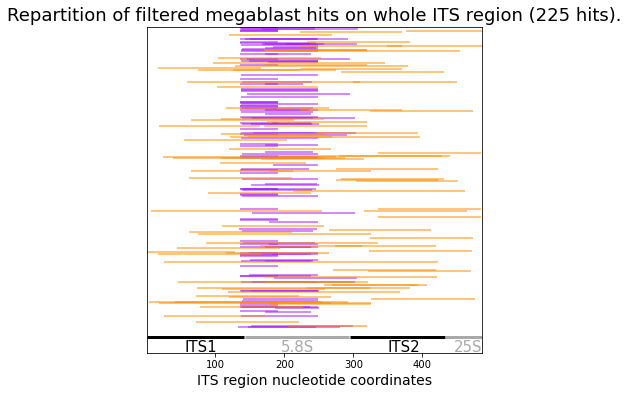

In [21]:
fig, ax = plt.subplots()
fig.set_size_inches(6, 6)
ax.set_xlim(1, 486)
ax.set_ylim(-50, 1000)



list_start_dio = [start for start in wgs_v2_df[((wgs_v2_df["%identity"] >= 99) & (wgs_v2_df["evalue"] <= 10e-10) & 
                                           (wgs_v2_df["alignment_length"] >= 55) & (wgs_v2_df["q_start"] <= (433-15))) &
                                               ((wgs_v2_df["q_start"] >= (143-15)) & (wgs_v2_df["q_end"] <= (294+15)))
                                              ]["q_start"]]
list_end_dio = [end for end in wgs_v2_df[((wgs_v2_df["%identity"] >= 99) & (wgs_v2_df["evalue"] <= 10e-10) &
                                     (wgs_v2_df["alignment_length"] >= 55) & (wgs_v2_df["q_start"] <= (433-15))) &
                                         ((wgs_v2_df["q_start"] >= (143-15)) & (wgs_v2_df["q_end"] <= (294+15)))
                                        ]["q_end"]]

for n in range(len(list_start_dio)):
    y = random.randrange(30,1000,1)
    list_start_dio[n] = (list_start_dio[n], y)
    list_end_dio[n] = (list_end_dio[n], y)




list_start_diohu = [start for start in wgs_v2_df[(wgs_v2_df["evalue"] <= 10e-10) & 
                                           ((wgs_v2_df["q_start"] <= (143-15)) | (wgs_v2_df["q_end"] >= (294+15))) & 
                                           (wgs_v2_df["q_start"] <= (433-15))]["q_start"]]
list_end_diohu = [end for end in wgs_v2_df[(wgs_v2_df["evalue"] <= 10e-10) & 
                                           ((wgs_v2_df["q_start"] <= (143-15)) | (wgs_v2_df["q_end"] >= (294+15))) & 
                                           (wgs_v2_df["q_start"] <= (433-15))]["q_end"]]

for n in range(len(list_start_diohu)):
    y = random.randrange(30,1000,1)
    list_start_diohu[n] = (list_start_diohu[n], y)
    list_end_diohu[n] = (list_end_diohu[n], y)
    

seg_dio = LineCollection(zip(list_start_dio, list_end_dio), colors="#A717FF", linewidths=2, alpha=0.5)
seg_diohu = LineCollection(zip(list_start_diohu, list_end_diohu), colors="darkorange", linewidths=2, alpha=0.5)

its = LineCollection([
                      [(1, 0), (142, 0)], 
                      [(143, 0), (294, 0)], 
                      [(295, 0), (432, 0)], 
                      [(433, 0), (486, 0)]
                      ], 
                     colors=["black", "darkgray", "black", "darkgray"], linewidths=3)

ax.add_collection(seg_dio)
ax.add_collection(seg_diohu)
ax.add_collection(its)

plt.annotate("ITS1", xy=(55, -45), color="black", fontsize=15)
plt.annotate("5.8S", xy=(195, -45), color="darkgray", fontsize=15)
plt.annotate("ITS2", xy=(350, -45), color="black", fontsize=15)
plt.annotate("25S", xy=(445, -45), color="darkgray", fontsize=15)
plt.yticks([])
plt.xlabel("ITS region nucleotide coordinates", size=14)


plt.title(f"Repartition of filtered megablast hits on whole ITS region ({len(list_end_dio)+len(list_end_diohu)} hits).", size=18)
plt.show()

#### Session information and modules

In [22]:
%load_ext watermark
%watermark -t -d -v -m
print("")
%watermark -w -p pandas,geopandas,shapely,matplotlib,geopy,jupyterlab

Python implementation: CPython
Python version       : 3.10.2
IPython version      : 7.30.1

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 165 Stepping 3, GenuineIntel
CPU cores   : 12
Architecture: 64bit


pandas    : 1.4.3
geopandas : 0.10.2
shapely   : 1.8.0
matplotlib: 3.5.1
geopy     : 2.2.0
jupyterlab: 3.3.4

Watermark: 2.3.1

